In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta


#250 company market screener
nasdaq_file = '/Users/victory/Desktop/AI Coursework/nasdaq_screener_1705443768175.csv' 




nasdaq_constituents = pd.read_csv(nasdaq_file)


nasdaq_data = nasdaq_constituents[['Symbol', 'IPO Year']]

# Set a default start date for historical data retrieval to 20 years ago
default_start_date = (datetime.now() - timedelta(days=20*365)).strftime('%Y-%m-%d')

# function to get historical data and calculate additional financial indicators
def get_financial_data(symbol, ipo_year):
    start_date = default_start_date if pd.isna(ipo_year) else max(str(int(ipo_year)) + '-01-01', default_start_date)
    end_date = datetime.now().strftime('%Y-%m-%d')
    try:
        ticker = yf.Ticker(symbol)
        history = ticker.history(start=start_date, end=end_date)

        # Calculate additional financial indicators
        history['50_MA_Close'] = history['Close'].rolling(window=50).mean()
        history['200_MA_Close'] = history['Close'].rolling(window=200).mean()
        history['Volume_MA_50'] = history['Volume'].rolling(window=50).mean()
        history['RSI'] = compute_rsi(history['Close'])
        history['MACD'] = compute_macd(history['Close'])
        history['Upper_Bollinger'], history['Lower_Bollinger'] = compute_bollinger_bands(history['Close'])
        
        return history
    except Exception as e:
        print(f"Failed to download data for {symbol}. Error: {e}")
        return None

# function to compute the Relative Strength Index (RSI)


def compute_rsi(data, time_window=14):
    diff = data.diff(1).dropna()        
    gain = 0 * diff
    loss = 0 * diff
    gain[diff > 0] = diff[diff > 0]
    loss[diff < 0] = -diff[diff < 0]
    avg_gain = gain.ewm(com=time_window - 1, min_periods=time_window).mean()
    avg_loss = loss.ewm(com=time_window - 1, min_periods=time_window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

#function to compute the Moving Average Convergence Divergence (MACD)




def compute_macd(data, slow=26, fast=12, smooth=9):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=smooth, adjust=False).mean()
    return macd - signal

#function to compute Bollinger Bands
def compute_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data.rolling(window).mean()
    rolling_std = data.rolling(window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

#retrieving historical data and financial metrics for each company
historical_data = {}
for index, row in nasdaq_data.iterrows():
    symbol = row['Symbol']
    ipo_year = row['IPO Year']
    print(f"Retrieving data for {symbol}...")
    historical_data[symbol] = get_financial_data(symbol, ipo_year)


first_symbol = nasdaq_data.iloc[0]['Symbol']
print(f"Historical data for {first_symbol}:")
print(historical_data[first_symbol].head())


nasdaq_file = '/Users/victory/Desktop/AI Coursework/nasdaq_screener_1705443768175.csv' 





Retrieving data for AAPL...
Retrieving data for ABNB...
Retrieving data for ACGL...
Retrieving data for ADBE...
Retrieving data for ADI...
Retrieving data for ADP...
Retrieving data for ADSK...
Retrieving data for AEP...
Retrieving data for AFRM...
Retrieving data for AGNCL...
Retrieving data for AGNCM...
Retrieving data for AGNCN...
Retrieving data for AGNCO...
Retrieving data for AGNCP...
Retrieving data for AKAM...
Retrieving data for ALGN...
Retrieving data for ALNY...
Retrieving data for AMAT...
Retrieving data for AMD...
Retrieving data for AMGN...
Retrieving data for AMZN...
Retrieving data for ANSS...
Retrieving data for APP...
Retrieving data for ARCC...
Retrieving data for ARGX...
Retrieving data for ARM...
Retrieving data for ASML...
Retrieving data for AVGO...
Retrieving data for AXON...
Retrieving data for AZN...
Retrieving data for AZPN...
Retrieving data for BGNE...
Retrieving data for BIDU...
Retrieving data for BIIB...
Retrieving data for BKNG...
Retrieving data for BK

In [2]:
first_symbol = nasdaq_data.iloc[0]['Symbol']
print(f"Historical data for {first_symbol}:")
print(historical_data[first_symbol].tail())

Historical data for AAPL:
                                 Open        High         Low       Close  \
Date                                                                        
2024-01-31 00:00:00-05:00  187.039993  187.100006  184.350006  184.399994   
2024-02-01 00:00:00-05:00  183.990005  186.949997  183.820007  186.860001   
2024-02-02 00:00:00-05:00  179.860001  187.330002  179.250000  185.850006   
2024-02-05 00:00:00-05:00  188.149994  189.250000  185.839996  187.679993   
2024-02-06 00:00:00-05:00  186.860001  189.309998  186.770004  189.300003   

                              Volume  Dividends  Stock Splits  50_MA_Close  \
Date                                                                         
2024-01-31 00:00:00-05:00   55467800        0.0           0.0   190.818999   
2024-02-01 00:00:00-05:00   64885400        0.0           0.0   190.762399   
2024-02-02 00:00:00-05:00  102518000        0.0           0.0   190.650399   
2024-02-05 00:00:00-05:00   69668800        

In [3]:
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
def convert_to_dataframe(historical_data):
 
    all_stocks_data = []


    for symbol, data in historical_data.items():
        # Reset index to make Date a column
        data.reset_index(inplace=True)
        
        # Add the stock symbol as a column
        data['Symbol'] = symbol


        all_stocks_data.append(data)

    # Concatenate all stocks data into a single DataFrame
    combined_data = pd.concat(all_stocks_data)

    return combined_data

# Apply the function to convert the historical data to a DataFrame
data_df = convert_to_dataframe(historical_data)



In [5]:

data_df.to_csv('/Users/victory/Desktop/AI Coursework/stock_data.csv', index=False)



In [6]:

#nasdaq_data got from financial modelling prep.com api
nasdaq_data = pd.read_csv('/Users/victory/Desktop/AI Coursework/nasdaq_constituents.csv')
stock_data = pd.read_csv('/Users/victory/Desktop/AI Coursework/stock_data.csv')

# Merging the datasets
merged_data = pd.merge(stock_data, nasdaq_data, left_on='Symbol', right_on='symbol', how='left')

# Creating a new 'status' column and setting initial values to 'Unchanged'
merged_data['status'] = 'Unchanged'

# Updating 'status' based on 'symbol' (added ticker) and 'removedTicker'
# Set to 'Removed' if the ticker appears in both 'symbol' and 'removedTicker'
removed_mask = (merged_data['Symbol'] == merged_data['removedTicker']) & (merged_data['Symbol'] == merged_data['symbol'])
merged_data.loc[removed_mask, 'status'] = 'Removed'

# Set to 'Added' if the ticker appears in the 'symbol' column but not as the same value in 'removedTicker'
added_mask = (merged_data['Symbol'] == merged_data['symbol']) & (merged_data['Symbol'] != merged_data['removedTicker'])
merged_data.loc[added_mask, 'status'] = 'Added'

# Convert the 'date' column to datetime with explicit format
merged_data['date'] = pd.to_datetime(merged_data['date'], format='%d/%m/%Y', errors='coerce')

# Get the current date as timezone-naive
current_date = pd.to_datetime('now').tz_localize(None)

# Calculate the 'days_since_change'
merged_data['days_since_change'] = (current_date - merged_data['date']).dt.days

# Displaying the updated merged dataset
print(merged_data.head())



                        Date      Open      High       Low     Close  \
0  2004-02-12 00:00:00-05:00  0.357388  0.363140  0.357237  0.359204   
1  2004-02-13 00:00:00-05:00  0.361021  0.364805  0.345581  0.348154   
2  2004-02-17 00:00:00-05:00  0.349668  0.355571  0.349668  0.350576   
3  2004-02-18 00:00:00-05:00  0.350879  0.354814  0.348911  0.352090   
4  2004-02-19 00:00:00-05:00  0.353149  0.357842  0.339224  0.340131   

      Volume  Dividends  Stock Splits  50_MA_Close  200_MA_Close  ...  Symbol  \
0  183988000        0.0           0.0          NaN           NaN  ...    AAPL   
1  315980000        0.0           0.0          NaN           NaN  ...    AAPL   
2  170956800        0.0           0.0          NaN           NaN  ...    AAPL   
3  141635200        0.0           0.0          NaN           NaN  ...    AAPL   
4  323080800        0.0           0.0          NaN           NaN  ...    AAPL   

          dateAdded  addedSecurity  removedTicker  removedSecurity       date  \

/Users/victory/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2224: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [7]:

# Convert 'Date' and 'date' columns to datetime in UTC
merged_data['Date'] = pd.to_datetime(merged_data['Date'], utc=True)
merged_data['date'] = pd.to_datetime(merged_data['date'], utc=True)




merged_data.rename(columns={'symbol': 'Symbol_Added', 'Symbol': 'Symbol_Tracked', 'removedTicker': 'Symbol_Removed'}, inplace=True)


nasdaq_constituents_path = '/Users/victory/Desktop/AI Coursework/nasdaq_constituents.csv' 
nasdaq_constituents_df = pd.read_csv(nasdaq_constituents_path)

# create a set of currently active NASDAQ-100 tickers from the nasdaq_constituents.csv file

active_tickers = set(nasdaq_constituents_df['symbol'].unique())

#  create a column 'Currently_in_NASDAQ100' 
# initialize it with 1 for tickers present in the active_tickers set
merged_data['Currently_in_NASDAQ100'] = merged_data['Symbol_Tracked'].apply(lambda x: 1 if x in active_tickers else 0)

# Show the updated dataframe with the new column
merged_data[['Symbol_Tracked', 'Symbol_Added', 'Symbol_Removed', 'Currently_in_NASDAQ100']].head()







,Symbol_Tracked,Symbol_Added,Symbol_Removed,Currently_in_NASDAQ100
0,AAPL,AAPL,NaN,1
1,AAPL,AAPL,NaN,1
2,AAPL,AAPL,NaN,1
3,AAPL,AAPL,NaN,1
4,AAPL,AAPL,NaN,1


In [8]:
merged_data['price_increase'] = (merged_data['Close'] > merged_data['Close'].shift(1)).astype(int)



In [9]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434180 entries, 0 to 1434179
Data columns (total 27 columns):
 #   Column                  Non-Null Count    Dtype              
---  ------                  --------------    -----              
 0   Date                    1434180 non-null  datetime64[ns, UTC]
 1   Open                    1434180 non-null  float64            
 2   High                    1434180 non-null  float64            
 3   Low                     1434180 non-null  float64            
 4   Close                   1434180 non-null  float64            
 5   Volume                  1434180 non-null  int64              
 6   Dividends               1434180 non-null  float64            
 7   Stock Splits            1434180 non-null  float64            
 8   50_MA_Close             1416932 non-null  float64            
 9   200_MA_Close            1364308 non-null  float64            
 10  Volume_MA_50            1416932 non-null  float64            
 11  RSI        

In [10]:


data = merged_data.copy()




In [11]:
#redoing stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

key_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Set display option to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

basic_statistics = data[key_columns].describe()
print(basic_statistics)




            Open       High        Low      Close        Volume
count 1434180.00 1434180.00 1434180.00 1434180.00    1434180.00
mean       74.98      75.99      73.97      75.00    7957371.39
std       130.60     132.27     128.91     130.61   40047758.35
min         0.05       0.05       0.04       0.05          0.00
25%        17.09      17.34      16.82      17.09     786300.00
50%        35.82      36.29      35.32      35.83    1902300.00
75%        82.50      83.58      81.44      82.53    4576300.00
max      3653.07    3669.66    3605.43    3644.94 3372969600.00


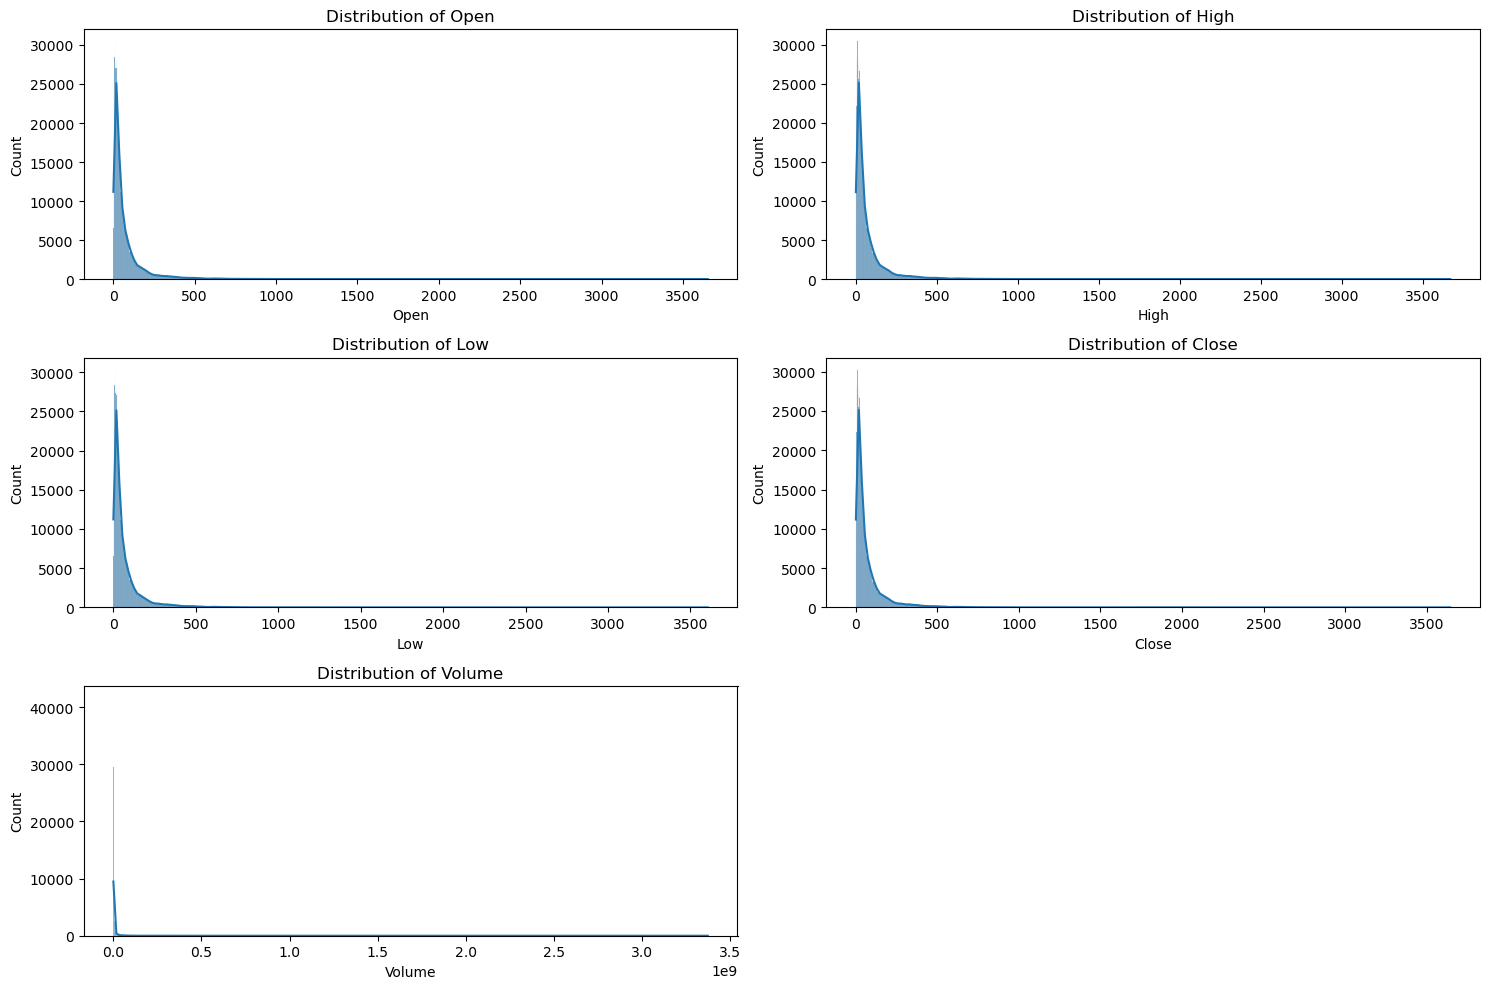

In [12]:

# Visualizing distributions of key columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(key_columns):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

Basic Statistical Overview:
             Open       High        Low      Close        Volume
count 1434180.00 1434180.00 1434180.00 1434180.00    1434180.00
mean       74.98      75.99      73.97      75.00    7957371.39
std       130.60     132.27     128.91     130.61   40047758.35
min         0.05       0.05       0.04       0.05          0.00
25%        17.09      17.34      16.82      17.09     786300.00
50%        35.82      36.29      35.32      35.83    1902300.00
75%        82.50      83.58      81.44      82.53    4576300.00
max      3653.07    3669.66    3605.43    3644.94 3372969600.00


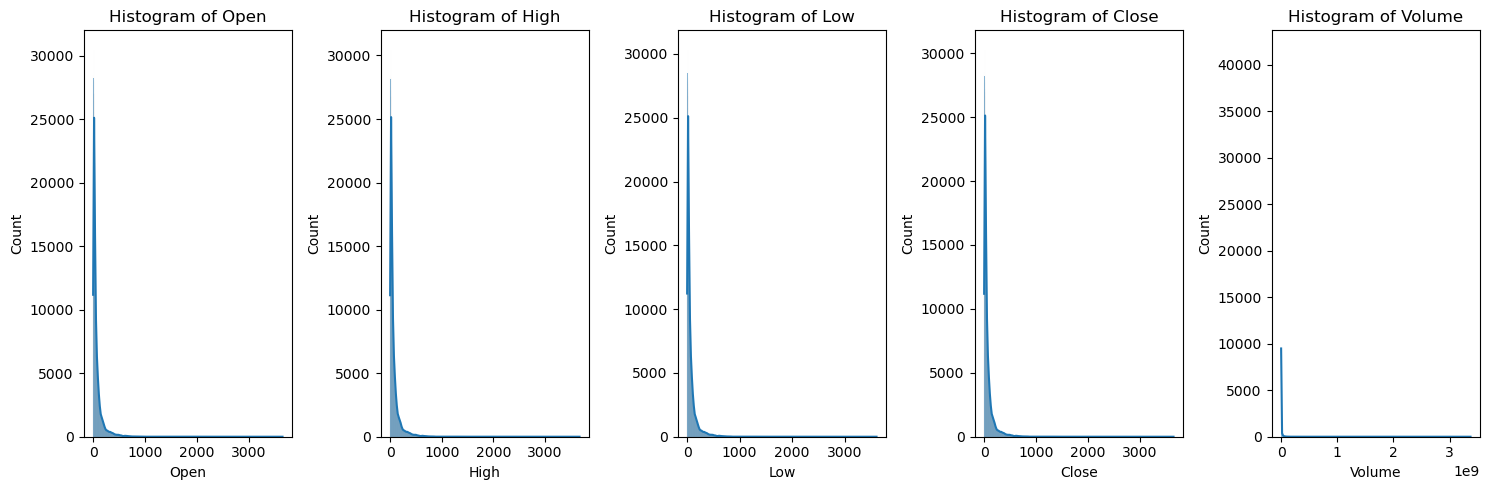

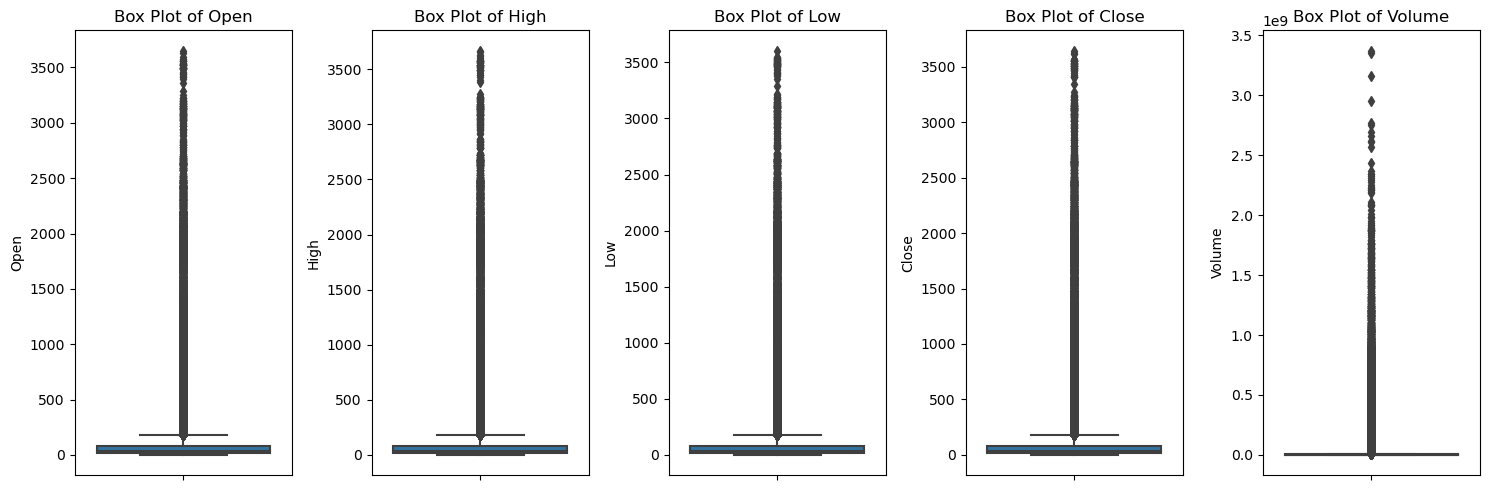

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


key_columns = ['Open', 'High', 'Low', 'Close', 'Volume']


pd.set_option('display.float_format', '{:.2f}'.format)


basic_statistics = data[key_columns].describe()


print("Basic Statistical Overview:\n", basic_statistics)


plt.figure(figsize=(15, 5))
for i, column in enumerate(key_columns):
    plt.subplot(1, len(key_columns), i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')
plt.tight_layout()
plt.show()

# Plot box plots
plt.figure(figsize=(15, 5))
for i, column in enumerate(key_columns):
    plt.subplot(1, len(key_columns), i + 1)
    sns.boxplot(y=data[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()



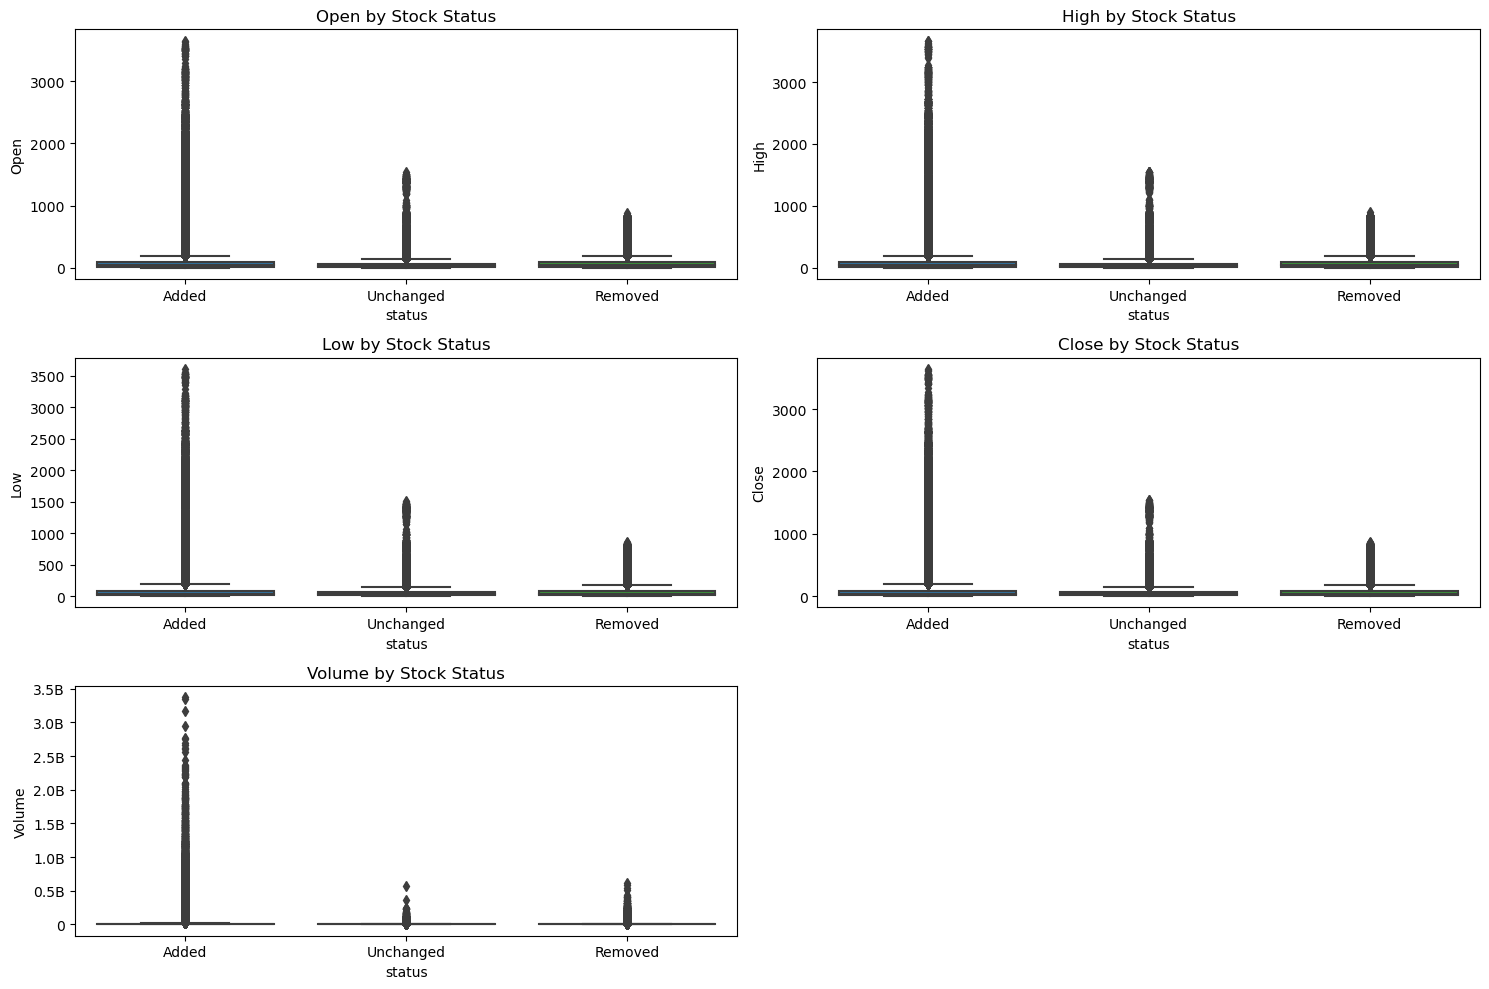

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as ticker


# 
key_metrics = ['Open', 'High', 'Low', 'Close', 'Volume']

# Creating boxplots for each key metric based on stock status
plt.figure(figsize=(15, 10))
for i, metric in enumerate(key_metrics):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x='status', y=metric, data=data)
    plt.title(f'{metric} by Stock Status')
plt.tight_layout()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def custom_formatter(x, pos):
    if x >= 1e8:  # 0.1 billion or higher
        val_str = '{:.1f}B'.format(x / 1e9)
    else:  # Less than 0.1 billion
        val_str = str(int(x))
    return val_str


plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))


plt.show()







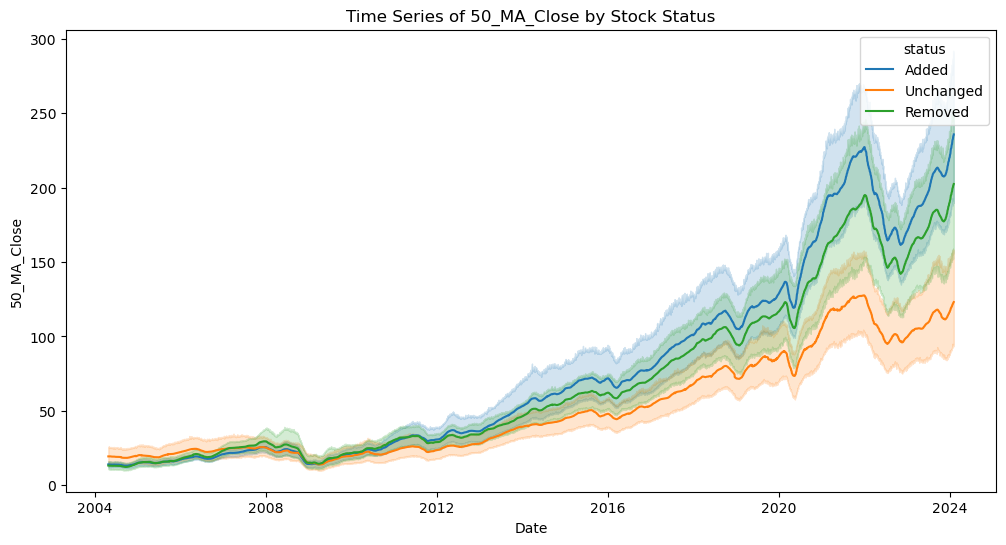

In [15]:

# Choose a metric for analysis, e.g., '50_MA_Close' for 50-day moving average
metric = '50_MA_Close'

# Create a time-series plot for this metric around the addition/removal date
# Assuming you have a way to identify the relevant time period around status change
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y=metric, hue='status', data=merged_data)
plt.title(f'Time Series of {metric} by Stock Status')
plt.show()





In [16]:
# Finding the earliest financial data date for each ticker
earliest_dates = data.groupby('Symbol_Tracked')['Date'].min()

def count_changes(data, earliest_dates):
    #Filter out rows where the change date is before the earliest date for that ticker
    filtered_data = data[data.apply(lambda row: row['date'] >= earliest_dates.get(row['Symbol_Tracked'], pd.Timestamp('1970-01-01', tz='UTC')), axis=1)]
    # Count the changes
    added_counts = filtered_data['Symbol_Added'].value_counts()
    removed_counts = filtered_data['Symbol_Removed'].value_counts()
    return added_counts, removed_counts


added_counts, removed_counts = count_changes(data, earliest_dates)


combined_counts = added_counts.add(removed_counts, fill_value=0).sort_values(ascending=False)
most_changed_ticker_overall = combined_counts.idxmax()
most_added_ticker = added_counts.idxmax()
most_removed_ticker = removed_counts.idxmax()

print(f"The most frequently changed ticker overall is: {most_changed_ticker_overall}")
print(f"The most frequently added ticker is: {most_added_ticker}")
print(f"The most frequently removed ticker is: {most_removed_ticker}")

The most frequently changed ticker overall is: HOLX
The most frequently added ticker is: JBHT
The most frequently removed ticker is: WYNN


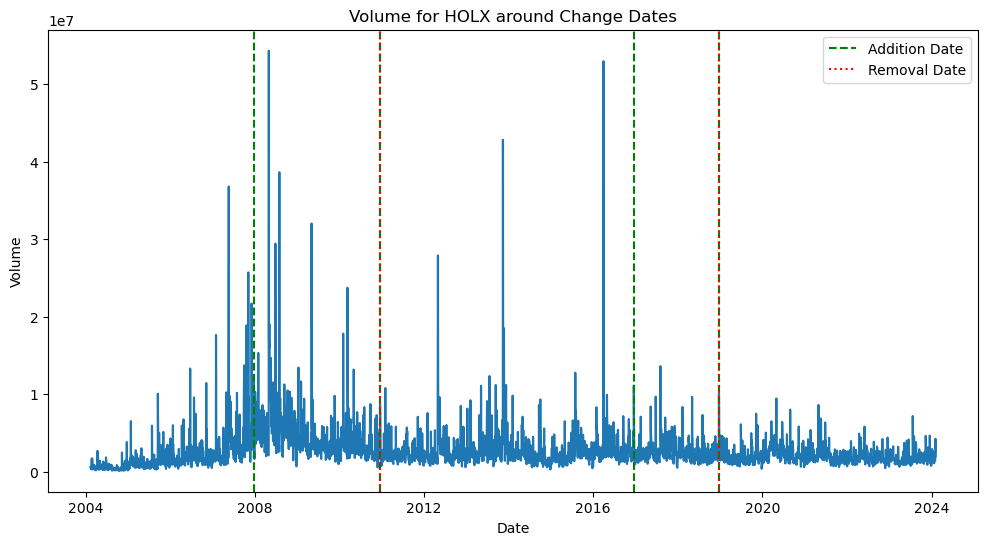

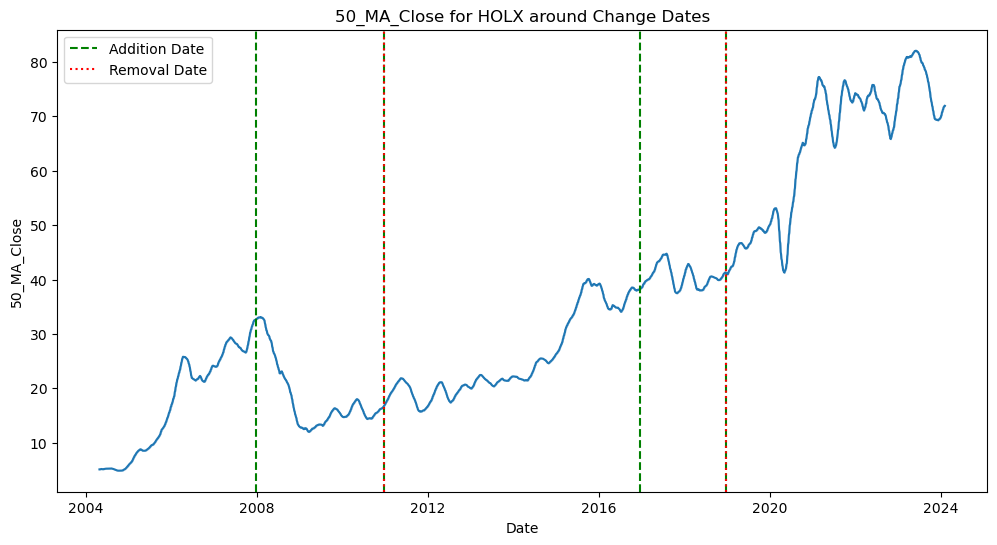

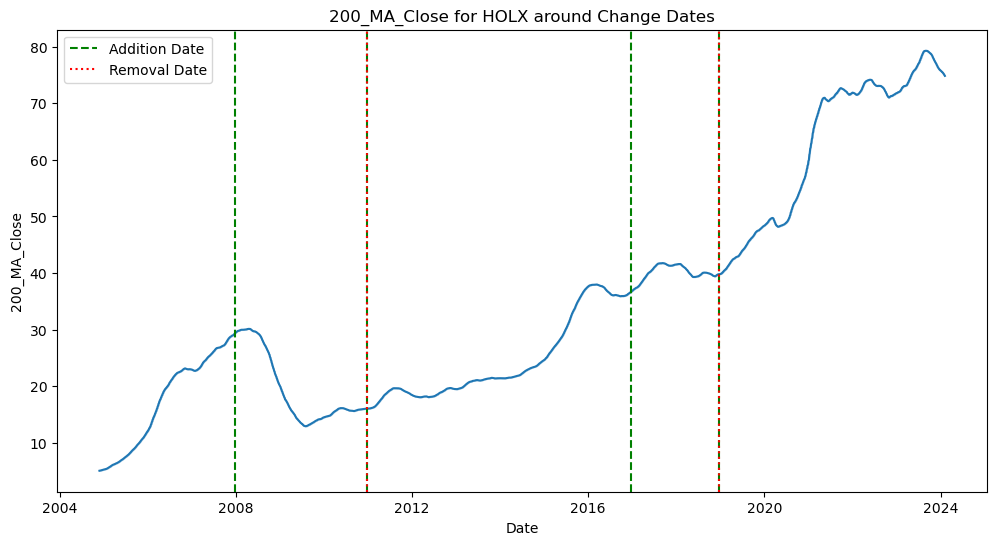

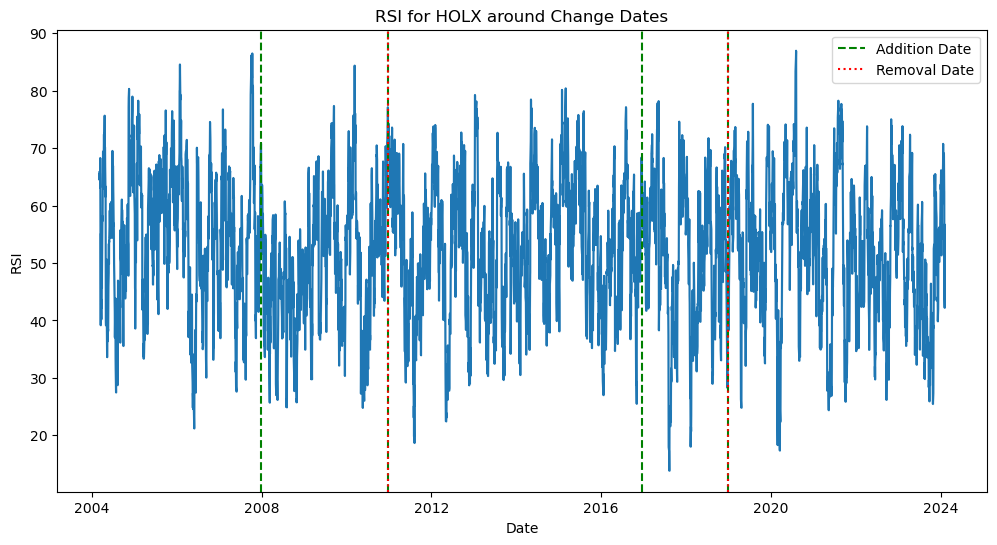

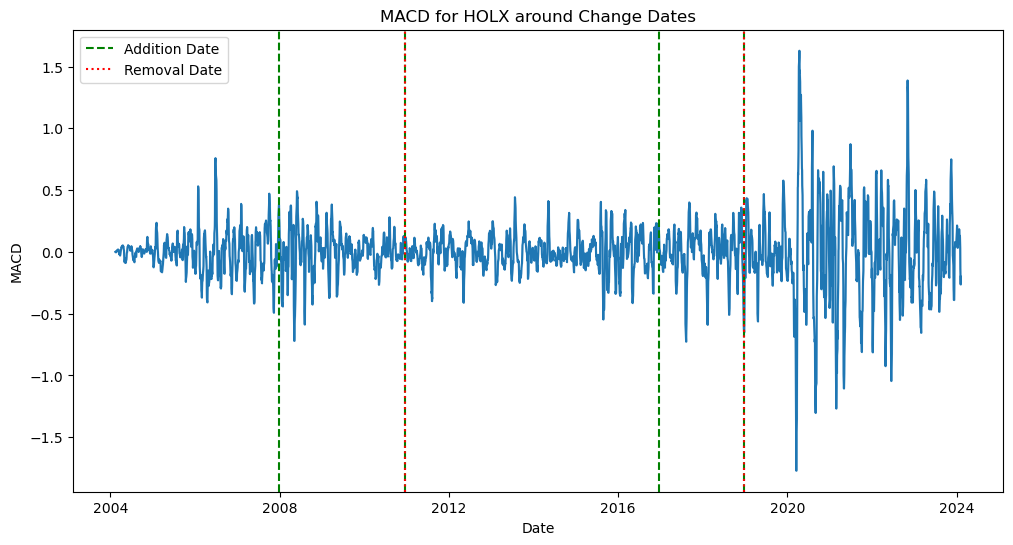

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


temp_data = merged_data[merged_data['Symbol_Tracked'] == 'HOLX']


#  function to plot time series around addition/removal dates
def plot_time_series_around_change(data, ticker, metrics):
    #
    addition_dates = data[data['Symbol_Added'] == ticker]['date'].unique()
    removal_dates = data[data['Symbol_Removed'] == ticker]['date'].unique()

    for metric in metrics:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='Date', y=metric, data=data)

        # Plotting addition dates
        for d in addition_dates:
            plt.axvline(x=d, color='green', linestyle='--', label='Addition Date' if d == addition_dates[0] else "")
        
        # Plotting removal dates
        for d in removal_dates:
            plt.axvline(x=d, color='red', linestyle=':', label='Removal Date' if d == removal_dates[0] else "")

        plt.title(f'{metric} for {ticker} around Change Dates')
        plt.legend()
        plt.show()


metrics = ['Volume', '50_MA_Close', '200_MA_Close', 'RSI', 'MACD']


plot_time_series_around_change(temp_data, 'HOLX', metrics)



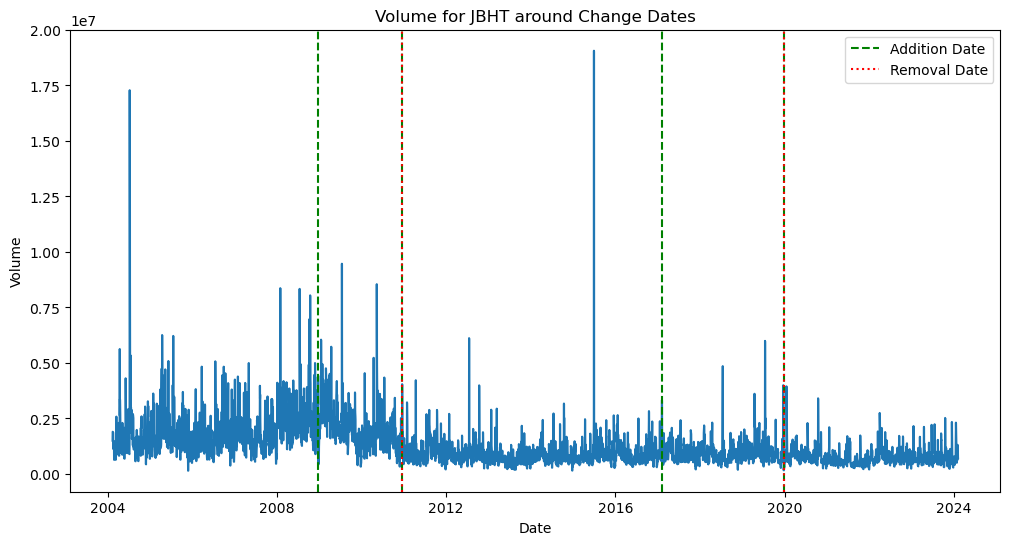

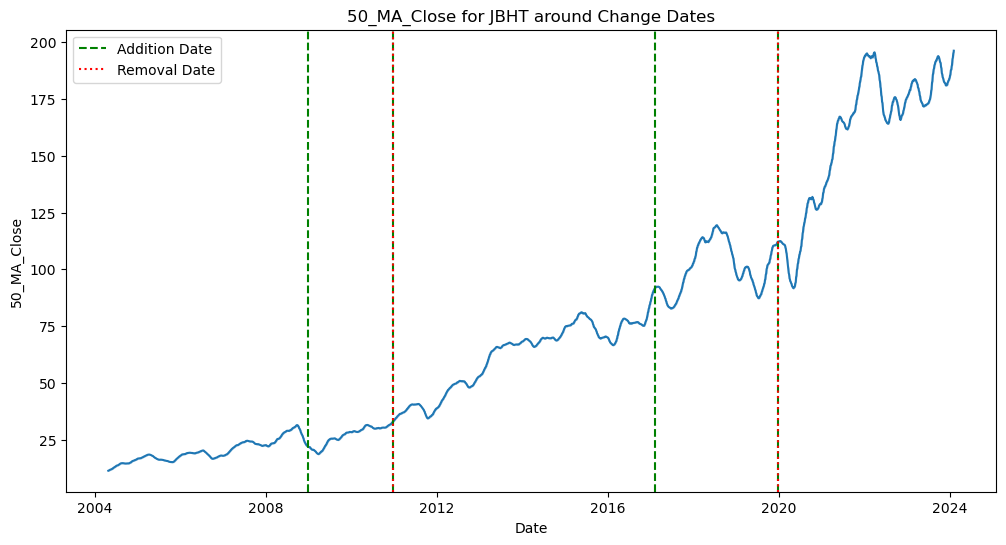

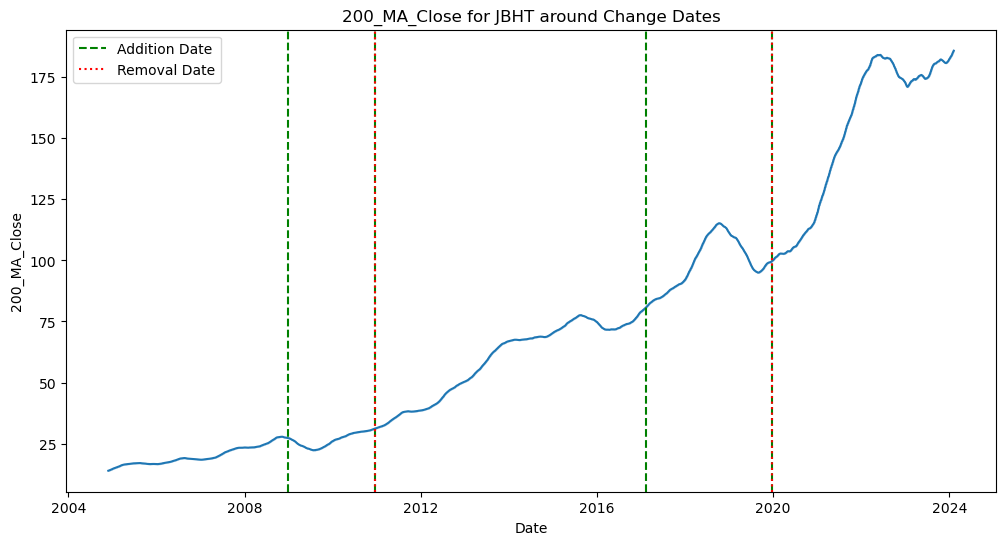

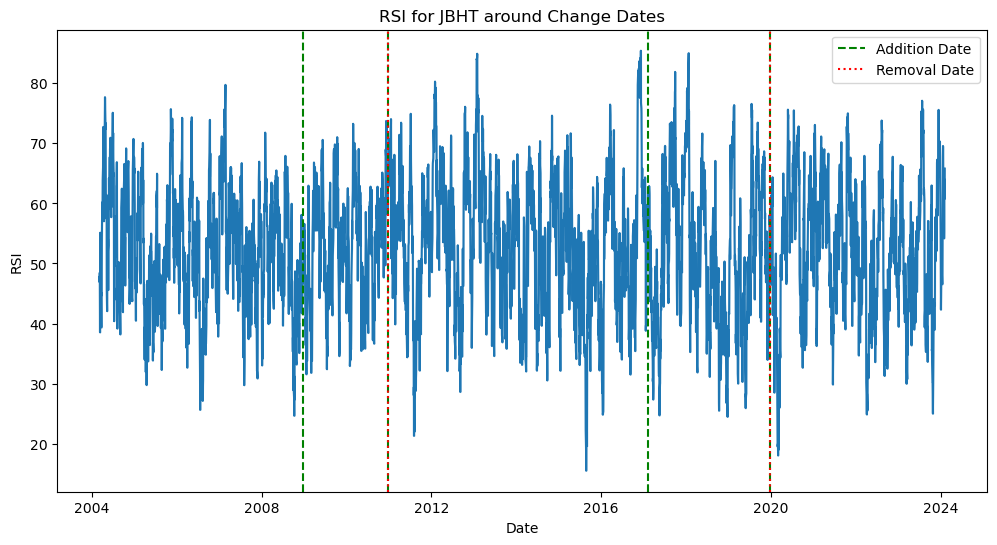

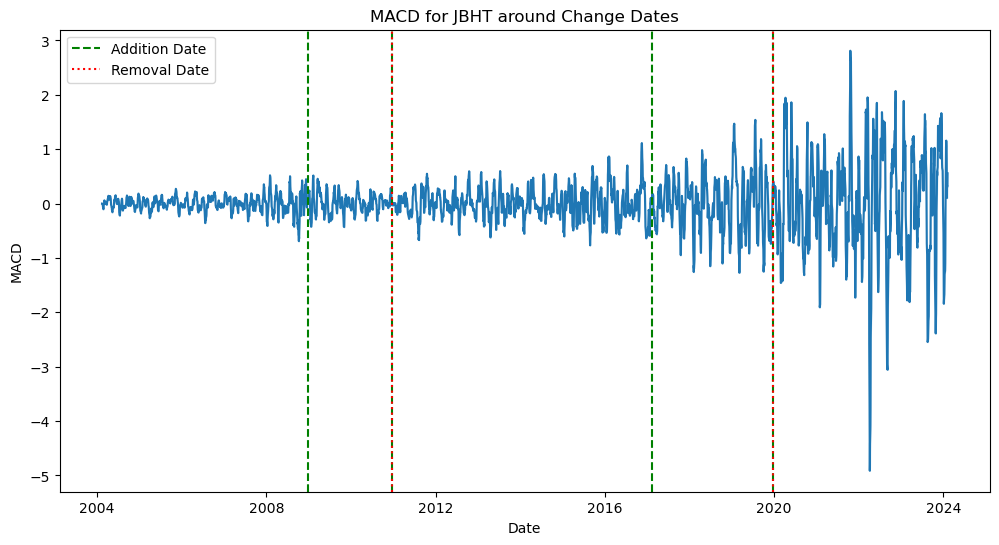

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

temp_data = merged_data[merged_data['Symbol_Tracked'] == 'JBHT']


# Define a function to plot time series around addition/removal dates
def plot_time_series_around_change(data, ticker, metrics):
    # Separate dates for additions and removals
    addition_dates = data[data['Symbol_Added'] == ticker]['date'].unique()
    removal_dates = data[data['Symbol_Removed'] == ticker]['date'].unique()

    for metric in metrics:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='Date', y=metric, data=data)

        # Plotting addition dates
        for d in addition_dates:
            plt.axvline(x=d, color='green', linestyle='--', label='Addition Date' if d == addition_dates[0] else "")
        
        # Plotting removal dates
        for d in removal_dates:
            plt.axvline(x=d, color='red', linestyle=':', label='Removal Date' if d == removal_dates[0] else "")

        plt.title(f'{metric} for {ticker} around Change Dates')
        plt.legend()
        plt.show()


metrics = ['Volume', '50_MA_Close', '200_MA_Close', 'RSI', 'MACD']




plot_time_series_around_change(temp_data, 'JBHT', metrics)




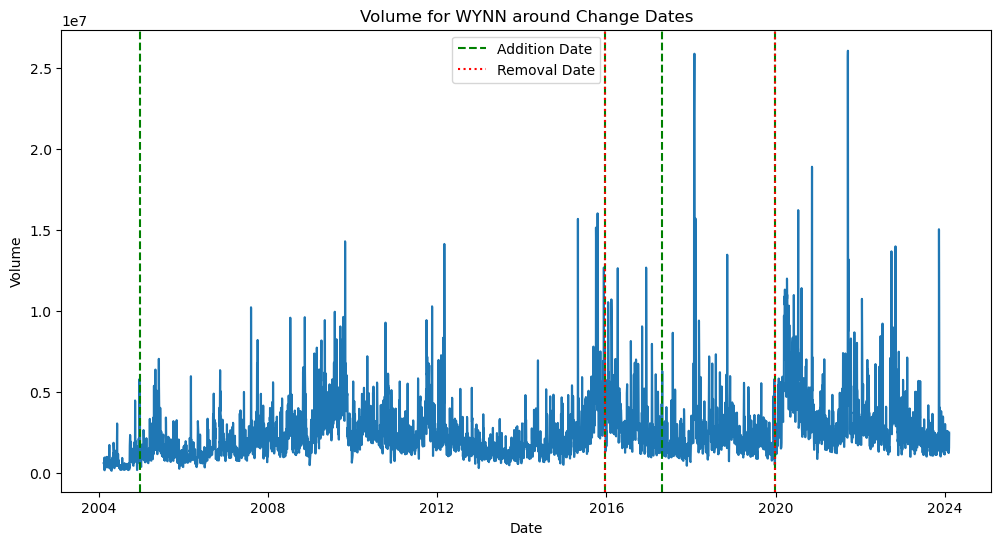

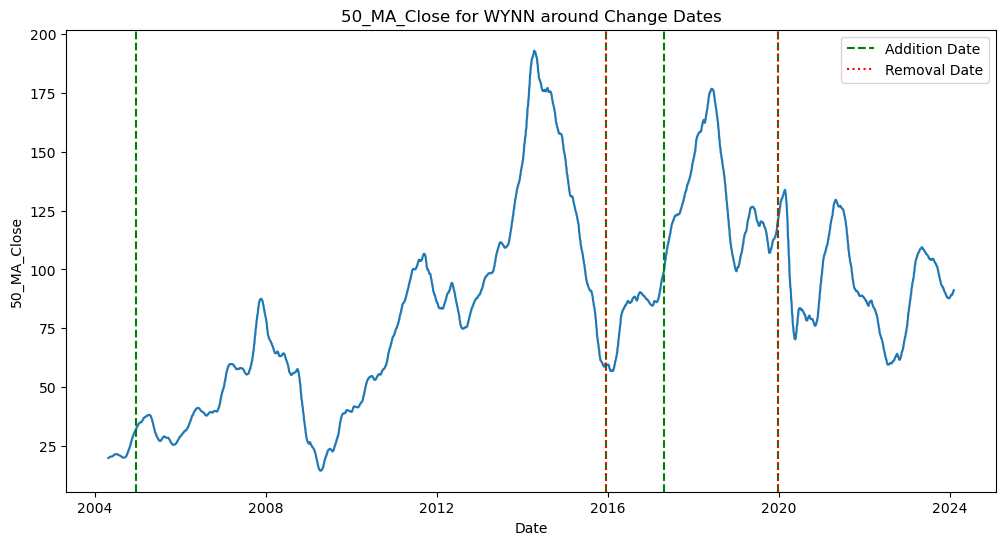

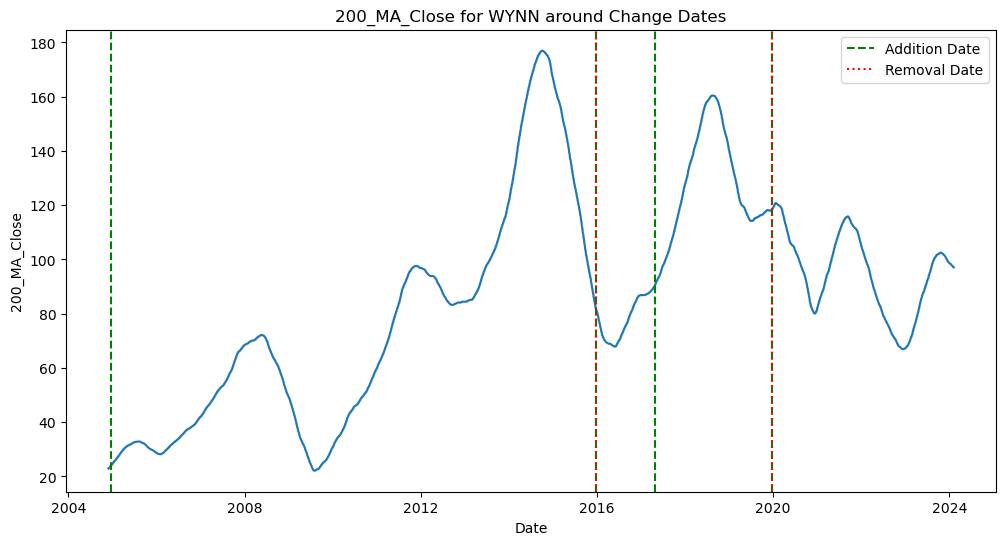

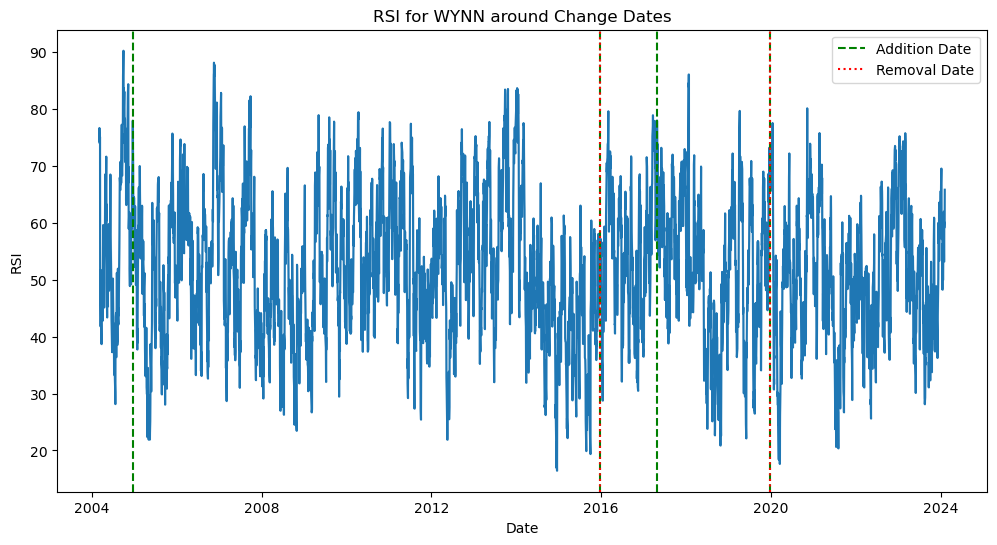

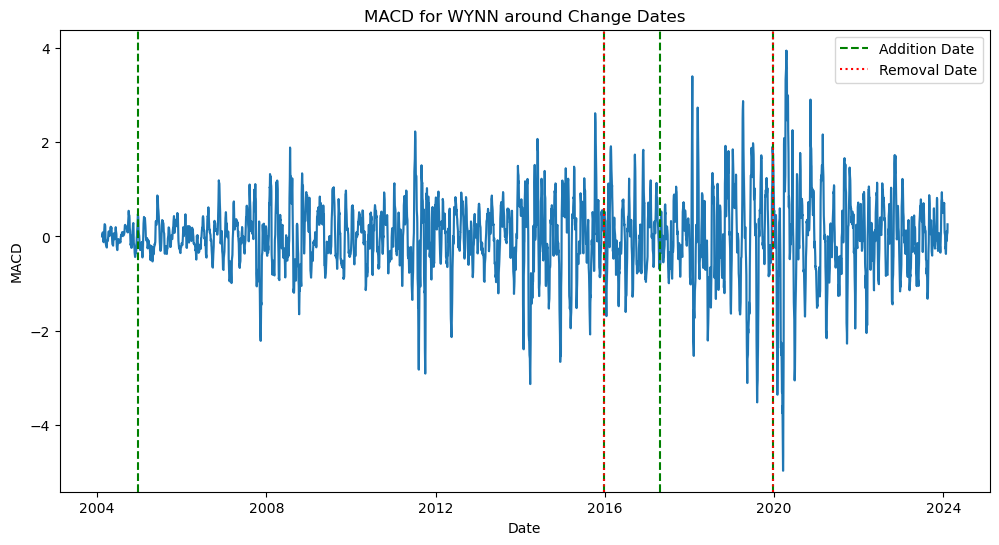

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


temp_data = merged_data[merged_data['Symbol_Tracked'] == 'WYNN']


# Define a function to plot time series around addition/removal dates
def plot_time_series_around_change(data, ticker, metrics):
    
    addition_dates = data[data['Symbol_Added'] == ticker]['date'].unique()
    removal_dates = data[data['Symbol_Removed'] == ticker]['date'].unique()

    for metric in metrics:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='Date', y=metric, data=data)

        # Plotting addition dates
        for d in addition_dates:
            plt.axvline(x=d, color='green', linestyle='--', label='Addition Date' if d == addition_dates[0] else "")
        
        # Plotting removal dates
        for d in removal_dates:
            plt.axvline(x=d, color='red', linestyle=':', label='Removal Date' if d == removal_dates[0] else "")

        plt.title(f'{metric} for {ticker} around Change Dates')
        plt.legend()
        plt.show()


metrics = ['Volume', '50_MA_Close', '200_MA_Close', 'RSI', 'MACD']



plot_time_series_around_change(temp_data, 'WYNN', metrics)




In [20]:
"""Reducing daataset size to reduce computation time"""
data = merged_data.head(100000).copy()

In [21]:
# Fill NaN values in moving averages with zeros
moving_average_columns = ['50_MA_Close', '200_MA_Close', 'Volume_MA_50']
for col in moving_average_columns:
    data[col].fillna(0, inplace=True)

# for categorical columns representing events, use a distinct value to represent 'None'
event_columns = ['Symbol_Added', 'Symbol_Removed', 'addedSecurity', 'days_since_change']
for col in event_columns:
    data[col].fillna(-1, inplace=True)
    



In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



# Convert and handle categorical columns
categorical_columns = ['addedSecurity', 'Symbol_Removed', 'removedSecurity', 'Date',
                       'Currently_in_NASDAQ100', 'Symbol_Added', 'status', 'Symbol_Tracked']
for col in categorical_columns:
    data[col] = data[col].astype(str)
    data[col] = LabelEncoder().fit_transform(data[col])

# Convert and handle numerical columns
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 
                     'Stock Splits', '50_MA_Close', '200_MA_Close', 'Volume_MA_50', 
                     'RSI', 'MACD', 'Upper_Bollinger', 'Lower_Bollinger', 
                     'days_since_change']
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.fillna(data.median(), inplace=True)  # Fill NaNs with median

# Combine categorical and numerical data
X = data[categorical_columns + numerical_columns]
y = data['price_increase']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply mutual information for feature selection(INSPECTION)
mi_scores = mutual_info_classif(X_train_scaled, y_train)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)

# Displaying mutual information scores for each feature
print("Mutual Information Scores:")
print(mi_scores.sort_values(ascending=False))

# Select top N features based on mutual information scores
N = 10
selected_features = mi_scores.iloc[:N].index


print(selected_features)



/var/folders/kd/3ks_j4mn1zv9kj6vc0swsln40000gn/T/ipykernel_62176/330368816.py:25: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.median(), inplace=True)  # Fill NaNs with median
/var/folders/kd/3ks_j4mn1zv9kj6vc0swsln40000gn/T/ipykernel_62176/330368816.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.median(), inplace=True)  # Fill NaNs with median


Mutual Information Scores:
days_since_change        0.12
Date                     0.08
Symbol_Tracked           0.07
Symbol_Added             0.07
addedSecurity            0.07
RSI                      0.05
MACD                     0.04
50_MA_Close              0.03
Volume_MA_50             0.03
200_MA_Close             0.03
removedSecurity          0.03
Lower_Bollinger          0.03
Low                      0.03
Volume                   0.03
Close                    0.03
Symbol_Removed           0.03
Open                     0.03
Upper_Bollinger          0.03
High                     0.03
status                   0.03
Currently_in_NASDAQ100   0.01
Dividends                0.00
Stock Splits             0.00
Name: MI Scores, dtype: float64
Index(['addedSecurity', 'Symbol_Removed', 'removedSecurity', 'Date',
       'Currently_in_NASDAQ100', 'Symbol_Added', 'status', 'Symbol_Tracked',
       'Open', 'High'],
      dtype='object')


In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

#  stratified k-fold object for cross-validation
strat_k_fold = StratifiedKFold(n_splits=5)  

# parameter grid for hyperparameter tuning
param_grid = {
    'C': np.logspace(-6, 1, 6),  # Expanded range of C
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']  # Include L2 penalty
}

#  GridSearchCV object with StratifiedKFold
grid_search = GridSearchCV(
    LogisticRegression(max_iter=10000), 
    param_grid=param_grid, 
    cv=strat_k_fold,
    scoring='accuracy',  # Consider using 'f1' or 'roc_auc' for imbalanced data
    n_jobs=-1
)

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

#Output the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

#Train the model with the best parameters
best_logistic_model = grid_search.best_estimator_

#Predict and evaluate on the test set
logistic_predictions = best_logistic_model.predict(X_test_scaled)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_f1_score = f1_score(y_test, logistic_predictions)

print(f'Logistic Regression Model Accuracy on Test Set: {logistic_accuracy}')
print(f'Logistic Regression Model F1 Score on Test Set: {logistic_f1_score}')



Best Parameters: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.7464
Logistic Regression Model Accuracy on Test Set: 0.74325
Logistic Regression Model F1 Score on Test Set: 0.6413855716181297


In [24]:
# Fill NaN values in moving averages with zeros
data = merged_data.head(100000).copy()
moving_average_columns = ['50_MA_Close', '200_MA_Close', 'Volume_MA_50']
for col in moving_average_columns:
    data[col].fillna(0, inplace=True)

# For categorical columns representing events, use a distinct value to represent 'None'
event_columns = ['Symbol_Added', 'Symbol_Removed', 'addedSecurity', 'days_since_change']
for col in event_columns:
    data[col].fillna(-1, inplace=True)
    

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


data = merged_data.head(100000).copy()


label_encoder = LabelEncoder()
categorical_columns = ['addedSecurity', 'Symbol_Removed', 'removedSecurity', 'Date',
                       'Currently_in_NASDAQ100', 'Symbol_Added', 'status', 'Symbol_Tracked']
for col in categorical_columns:
    data[col] = data[col].astype(str)
    data[col] = label_encoder.fit_transform(data[col])

numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 
                     'Stock Splits', '50_MA_Close', '200_MA_Close', 'Volume_MA_50', 
                     'RSI', 'MACD', 'Upper_Bollinger', 'Lower_Bollinger', 
                     'days_since_change']
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.fillna(data.median(), inplace=True)  # Fill NaNs with median


X = pd.concat([data[categorical_columns], data[numerical_columns]], axis=1)
y = data['price_increase']  # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  pipeline with SMOTE and XGBoost classifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__colsample_bytree': [0.5, 0.7],
    'classifier__subsample': [0.6, 0.8]
}


strat_k_fold = StratifiedKFold(n_splits=5)


grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=strat_k_fold, 
    scoring='accuracy', 
    n_jobs=1
)

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Train the model with the best parameters
best_xgb_model = grid_search.best_estimator_['classifier']

# Predict and evaluate on the test set using the full feature set
xgb_predictions = best_xgb_model.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_roc_auc = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_scaled)[:, 1])
xgb_f1_score = f1_score(y_test, xgb_predictions)

# Print evaluation metrics
print(f'XGBoost Model Accuracy on Test Set: {xgb_accuracy}')
print(f'XGBoost Model ROC AUC Score on Test Set: {xgb_roc_auc}')
print(f'XGBoost Model F1 Score on Test Set: {xgb_f1_score}')



/var/folders/kd/3ks_j4mn1zv9kj6vc0swsln40000gn/T/ipykernel_62176/3430565089.py:27: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.median(), inplace=True)  # Fill NaNs with median
/var/folders/kd/3ks_j4mn1zv9kj6vc0swsln40000gn/T/ipykernel_62176/3430565089.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.median(), inplace=True)  # Fill NaNs with median


Best Parameters: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best Score: 0.727725
XGBoost Model Accuracy on Test Set: 0.726
XGBoost Model ROC AUC Score on Test Set: 0.8377343450577409
XGBoost Model F1 Score on Test Set: 0.7177003915104059


In [26]:
"""Model 2, xgboost (with no data related to being in nasdaq 100)"""

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline



data = merged_data.head(100000).copy()

# Encode categorical variables
label_encoder = LabelEncoder()
categorical_columns = ['Date','Symbol_Tracked']
for col in categorical_columns:
    data[col] = data[col].astype(str)
    data[col] = label_encoder.fit_transform(data[col])

# Convert and handle numerical columns
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 
                     'Stock Splits', '50_MA_Close', '200_MA_Close', 'Volume_MA_50', 
                     'RSI', 'MACD', 'Upper_Bollinger', 'Lower_Bollinger']
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.fillna(data.median(), inplace=True)  # Fill NaNs with median


X = pd.concat([data[categorical_columns], data[numerical_columns]], axis=1)
y = data['price_increase'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])


param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__colsample_bytree': [0.5, 0.7],
    'classifier__subsample': [0.6, 0.8]
}


strat_k_fold = StratifiedKFold(n_splits=5)


grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=strat_k_fold, 
    scoring='accuracy', 
    n_jobs=1
)
grid_search.fit(X_train_scaled, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_['classifier']


xgb_predictions = best_xgb_model.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_roc_auc = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_scaled)[:, 1])
xgb_f1_score = f1_score(y_test, xgb_predictions)


print(f'XGBoost Model Accuracy on Test Set: {xgb_accuracy}')
print(f'XGBoost Model ROC AUC Score on Test Set: {xgb_roc_auc}')
print(f'XGBoost Model F1 Score on Test Set: {xgb_f1_score}')

/var/folders/kd/3ks_j4mn1zv9kj6vc0swsln40000gn/T/ipykernel_62176/2583887653.py:30: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.median(), inplace=True)  # Fill NaNs with median
/var/folders/kd/3ks_j4mn1zv9kj6vc0swsln40000gn/T/ipykernel_62176/2583887653.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.median(), inplace=True)  # Fill NaNs with median


Best Parameters: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best Score: 0.7112875
XGBoost Model Accuracy on Test Set: 0.71165
XGBoost Model ROC AUC Score on Test Set: 0.7850954024252793
XGBoost Model F1 Score on Test Set: 0.6754094669893623
